# Orthogonal Transformation

In this notebook, I will be going over how we can implement a transformation over some dataset $X$.

Current transformations to try:

* Principal Components Analysis
* Random Rotations (SO group)
* Orthogonal ICA
* QR decomposition (TODO)
* LU decompostion (TODO)

In [4]:
import os, sys
cwd = os.getcwd()
sys.path.insert(0, f"{cwd}/../")

# Import RBIG Function
import numpy as np
from rbig.data import ToyData
from rbig.linear import OrthogonalTransform
# from rbig.ica import OrthogonalICA

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from sklearn.decomposition import fastica
from picard import picard

In [78]:
whitening, unmixing, sources, X_mean, n_iter_ = fastica(
            data,
            random_state=123,
            whiten=True,
            return_X_mean=True,
            return_n_iter=True,
        )
print(whitening.shape, unmixing.shape, sources.shape, X_mean.shape)

(2, 2) (2, 2) (10000, 2) (2,)


In [79]:
components = np.dot(unmixing, whitening)
A = np.dot(components.T, np.linalg.inv(np.dot(components, components.T)))
np.linalg.slogdet(components)[1], np.linalg.slogdet(A)[1], 

(-8.277791878192316, 8.277791878192314)

In [87]:
whitening, unmixing, sources, X_mean, n_iter_ = picard(
            data.T,
            random_state=123,
            ortho=True,
            whiten=False,
            return_X_mean=True,
            return_n_iter=True,
        )
# print(whitening.shape, unmixing.shape, sources.shape, X_mean.shape)

In [88]:
if whitening is not None:
    components = np.dot(unmixing, whitening)
    A = np.dot(components.T, np.linalg.inv(np.dot(components, components.T)))
    print(np.linalg.slogdet(components)[1], np.linalg.slogdet(A)[1], )
else:
    print(np.linalg.slogdet(unmixing)[1])

9.159339953157541e-16


In [89]:
icao_clf = OrthogonalICA()
X_trans = icao_clf.fit_transform(data)

In [51]:
icao_clf.components_

array([[-0.98424315, -2.01818131],
       [-0.81696536,  0.90647558]])

In [90]:
np.linalg.slogdet(icao_clf.components_)[1]

9.159339953157541e-16

### Data

In [5]:
seed = 123
rng = np.random.RandomState(seed=seed)

data = ToyData('moons', 10000, 0.1, 123).generate_samples()
X = data[:, 0]
Y = data[:, 1]


<Figure size 360x360 with 0 Axes>

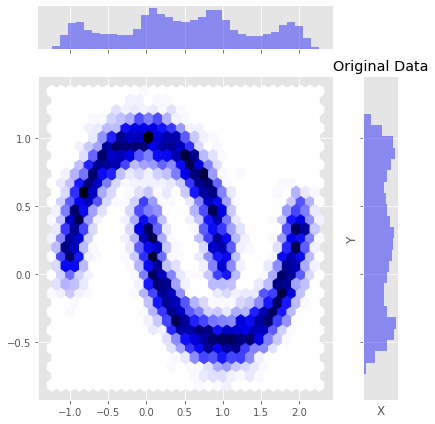

In [6]:
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

## Transformations

### Independent Components Analysis

We need to ensure that the unmixing matrix that the matrix used is orthogonal. So that changes the original implementation of the (fast)ICA algorithm. Fortunately, there is an implementation called the Preconditioned ICA under the orthogonality constraint by [Ablin et. al. (2018)][1]. Apparently it is faster and more robust than the original fastICA algorithm on real datasets.

[1]: https://arxiv.org/abs/1711.10873

In [35]:
rotation = 'ica'
random_state = 123

transformer = OrthogonalTransform(rotation=rotation, random_state=random_state,)

transformer.fit(data);

### Forward Transformation

<Figure size 360x360 with 0 Axes>

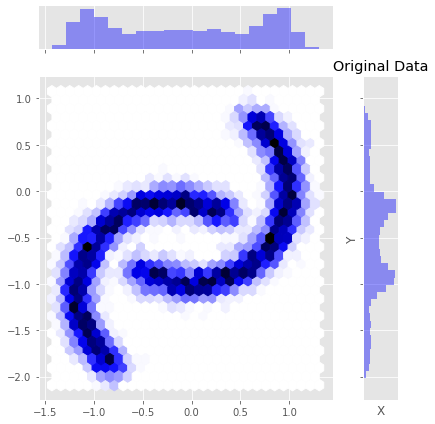

In [36]:
data_trans = transformer.transform(data)


fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data_trans[:, 0], y=data_trans[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

As you can see, with the ICA transformation, there is an obvious change in the shape of the data distribution.

#### Reverse Transform

<Figure size 360x360 with 0 Axes>

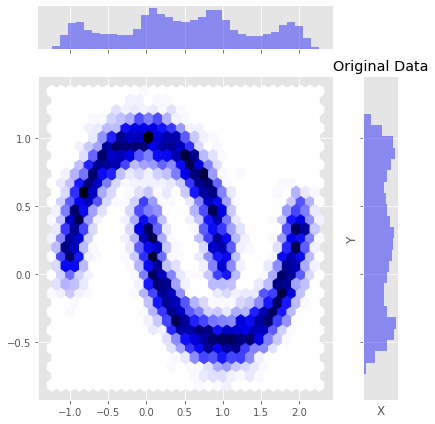

In [37]:
data_ori = transformer.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_ori, data)

# Plot
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data_ori[:, 0], y=data_ori[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

#### Log Determinant Jacobian

The nice thing about a linear transformation of an orthogonal matrix is that the log determinant Jacobian of the rotation matrix $R$ is zero or close to it. We can verify this like so:

In [38]:
# We can get the determinant for the transformation
det = np.linalg.slogdet(transformer.R)[1]

assert(det < 1e-12)

# we can also get the probability for the original data
nll = transformer.score(data, None)

assert(nll < 1e-12)

#### Score Samples (a.k.a. logdetjacobian)

This is always the problematic term. Normally we calculate this like so:

$$\log |\nabla f(x)|$$

But as we've shown above, the logdetjacobian is zero for any orthogonal transformation. Normally for a linear transformation:

$$\log |\nabla A| * O(N)$$

where $N$ is the number of samples. But in out case, we should get zero.

In [45]:
logprob = transformer.score_samples(data)

print(logprob)

[0. 0. 0. ... 0. 0. 0.]


---
### Principle Components Analysis

For the PCA algorithm, we seek a transformation that maximizes the variance in all directions. 

In [39]:
rotation = 'pca'
random_state = 123

transformer = OrthogonalTransform(rotation=rotation, random_state=random_state,)

transformer.fit(data);

#### Forward Transformation

<Figure size 360x360 with 0 Axes>

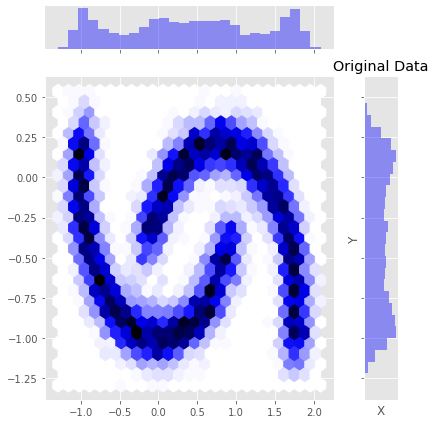

In [40]:
data_trans = transformer.transform(data)

fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data_trans[:, 0], y=data_trans[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

As you can see, not much has changed with this distribution, but you can see that the axis are slightly different. So there WAS a transformation. 

#### Reverse Transformation

In [41]:
data_ori = transformer.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_ori, data)

<Figure size 360x360 with 0 Axes>

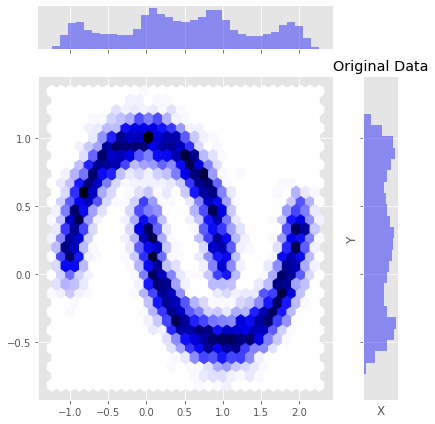

In [42]:
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data_ori[:, 0], y=data_ori[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

#### Log Determinant Jacobian


In [43]:
# We can get the determinant for the transformation
det = np.linalg.slogdet(transformer.R)[1]

assert(det < 1e-12)

# we can also get the probability for the original data
nll = transformer.score(data, None)

assert(nll < 1e-12)

#### Score Samples (a.k.a. logdetjacobian)


In [44]:
logprob = transformer.score_samples(data)

print(logprob)

[0. 0. 0. ... 0. 0. 0.]


### Random Rotation

<Figure size 360x360 with 0 Axes>

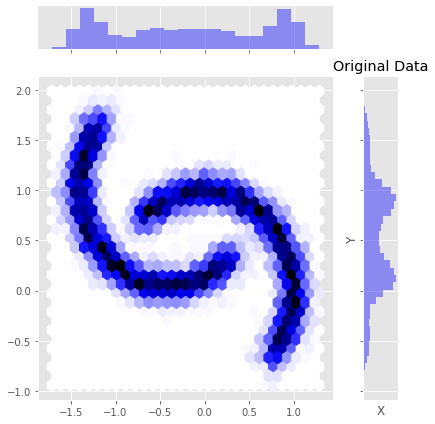

In [120]:
rotation = 'random_so'
random_state = 123

transformer = OrthogonalTransform(rotation=rotation, random_state=random_state,)

data_trans = transformer.fit_transform(data)

fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data_trans[:, 0], y=data_trans[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

In [121]:
data_ori = transformer.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_ori, data)

<Figure size 360x360 with 0 Axes>

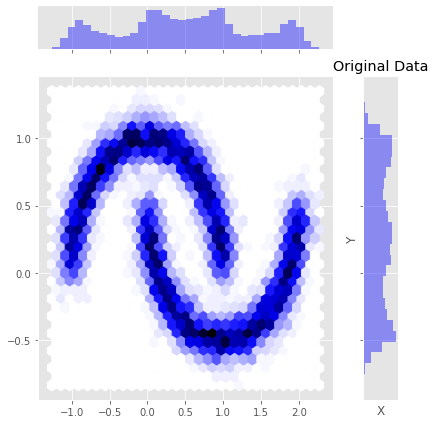

In [122]:
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data_ori[:, 0], y=data_ori[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

In [123]:
# We can get the determinant for the transformation
det = np.linalg.slogdet(transformer.R)[1]

assert(det < 1e-12)

# we can also get the probability for the original data
nll = transformer.score(data, None)

assert(nll < 1e-12)